# ***`Human Emotions Detection`***

**Problem Statement:**

The objective of this project is to create an automated system that accurately identifies the emotional state depicted in input images. Specifically, the system needs to distinguish between three primary emotions: happiness, sadness, and anger. This capability will enable applications in various domains such as facial recognition, sentiment analysis, and human-computer interaction, enhancing user experience and engagement in real-world scenarios.



\
**Dataset**:

We are going to use the `Human Emotions Dataset` available on kaggle [click here](https://www.kaggle.com/datasets/muhammadhananasghar/human-emotions-datasethes).


## 1. Import dependencies

In [1]:
!wget https://github.com/krutika-shimpi/Human_Emotion_Detection_Project/raw/main/helper_functions.py

--2024-07-14 15:54:58--  https://github.com/krutika-shimpi/Human_Emotion_Detection_Project/raw/main/helper_functions.py
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/krutika-shimpi/Human_Emotion_Detection_Project/main/helper_functions.py [following]
--2024-07-14 15:54:59--  https://raw.githubusercontent.com/krutika-shimpi/Human_Emotion_Detection_Project/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7796 (7.6K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   7.61K  --.-KB/s    in 0s      

2024-07-14 15:54:59 (81.6 MB/s)

In [2]:
# import libraries
from helper_functions import plot_loss_curves, make_confusion_matrix
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import cv2
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import datetime
import pathlib
import io
import os
import time
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from google.colab import drive

## 2. Get the data

Let's download the data from kaggle. We will import the data using the kaggle API.

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/muhammadhananasghar/human-emotions-datasethes
License(s): unknown
100% 308M/309M [00:05<00:00, 64.2MB/s]
100% 309M/309M [00:05<00:00, 60.2MB/s]


In [4]:
!unzip "/content/human-emotions-datasethes" -d "/content/dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/EmotionsDataset/data/nothing/720.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/721.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/722.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/723.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/724.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/725.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/726.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/727.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/728.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/729.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/73.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/730.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/731.jpg  
  inflating: /content/dataset/EmotionsDataset/data/no

## 3. Data Preparation

Creating datasets from an image directory using tf.keras.utils.image_dataset_from_directory. Setting up configurations for global variables ensures standardized parameters for dataset loading

### 3.1 Setting up important configurations and directories

In [5]:
# Setup the data directories
train_dir = "/content/dataset/Emotions Dataset/Emotions Dataset/train"
val_dir = "/content/dataset/Emotions Dataset/Emotions Dataset/test"
CLASS_NAMES = ['happy', 'sad', 'angry']

In [35]:
# Set up default configuration for global variables
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "N_EPOCHS": 10,
    "LEARNING_RATE": 0.001,
    "DROPOUT_RATE":0.0,
    "REGULARIZATION_RATE":0.0,
    "N_FILTERS":6,
    "KERNEL_SIZE": 3,
    "N_STRIDES":1,
    "POOL_SIZE":2,
    "N_DENSE_1": 100,
    "N_DENSE_2": 10,
    "NUM_CLASSES":3
}

### 3.2 Creating a training dataset from a directory of images.

In [33]:
# Setup training and validation datasets from the image directory
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory = train_dir,
    labels = 'inferred',
    label_mode = 'categorical', # Output will be a one hot encoded vector [0,1,0]:[happy, sad, angry]
    class_names = CLASS_NAMES,
    batch_size = 32,
    image_size = (256, 256),
    shuffle = True,
    seed = 99,
    color_mode = 'rgb',
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    directory = val_dir,
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = CLASS_NAMES,
    batch_size = CONFIGURATION['BATCH_SIZE'],
    image_size = (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    shuffle = True,
    seed = 99,
    color_mode = 'rgb',
)

Found 6799 files belonging to 3 classes.
Found 2278 files belonging to 3 classes.


### 3.3 Prefetching the dataset

In [36]:
# Create prefetched datasets
training_dataset = (train_dataset
                    .prefetch(tf.data.AUTOTUNE))

validation_dataset = (val_dataset
                      .prefetch(tf.data.AUTOTUNE))

## 4. Visualizing the dataset

Let's visualize some images from the datasets.

In [9]:
# Visualizing metadata
for i in val_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[ 20.        ,  20.        ,  20.        ],
         [ 19.1875    ,  19.1875    ,  19.1875    ],
         [ 19.        ,  19.        ,  19.        ],
         ...,
         [ 29.125     ,  29.125     ,  29.125     ],
         [ 25.        ,  25.        ,  25.        ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.        ,  20.        ,  20.        ],
         [ 19.847656  ,  19.847656  ,  19.847656  ],
         [ 19.8125    ,  19.8125    ,  19.8125    ],
         ...,
         [ 28.820312  ,  28.820312  ,  28.820312  ],
         [ 25.660156  ,  25.660156  ,  25.660156  ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.6875    ,  20.6875    ,  20.6875    ],
         [ 21.246094  ,  21.246094  ,  21.246094  ],
         [ 21.847656  ,  21.847656  ,  21.847656  ],
         ...,
         [ 25.3125    ,  25.3125    ,  25.3125    ],
         [ 22.375     ,  22.375     ,  22.375 

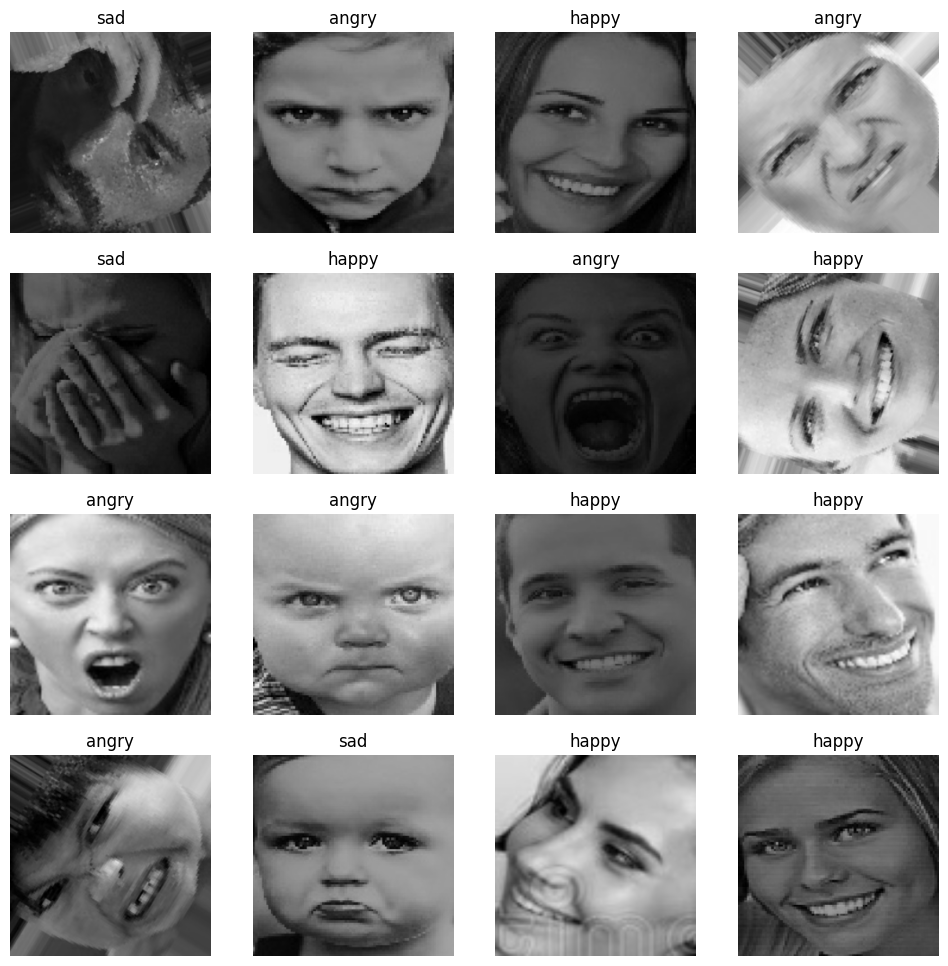

In [10]:
# Plot some images from the dataset
plt.figure(figsize = (12, 12))

for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i]/255.)
    plt.title(CLASS_NAMES[tf.argmax(labels[i], axis = 0).numpy()])
    plt.axis("off")

## 5. Modeling experiments

Let's now start working towards building the model, experimenting, documenting, and comparing the results of the models we build along the way.

### 5.1. Set up resize and rescale layers

Before building the model, let's set up resize and rescaling layer so that all images have same shape, size and pixel values in the range (0-255).

In [37]:
# Setting up resize and rescale methods as layers
resize_rescale_layers = tf.keras.Sequential([
    Resizing(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    Rescaling(1./255)
])

### 5.2 Data Augmentation

We ran our first experiment without the data augmentation and git around 80% accuracy. Let's now try our model with data augmentation to introduce robustness to the model and also try to reduce the overfitting in the model.


In [38]:
# Lets create a data augmentation layer
augment_layers = tf.keras.Sequential([
    RandomRotation(factor = (0.25, 0.2501)),
    RandomFlip(mode = 'horizontal'),
    RandomContrast(factor = 0.1)
])

def augment_layer(image, label):
  return augment_layers(image, training = True), label

In [39]:
# Applying data augmentation to the datasets
aug_train_dataset = (train_dataset
                    .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
                    .prefetch(tf.data.AUTOTUNE))

aug_val_dataset = (val_dataset
                  .prefetch(tf.data.AUTOTUNE))

### 5.2 Model_0 (Baseline): LeNet_model

We'll begin our modeling process with a straightforward LeNet architecture. This serves as a foundational baseline, which we'll iteratively refine through experimentation and tuning to enhance performance. This initial step allows us to establish a simple yet effective model, providing insights and a benchmark for subsequent improvements.

In [40]:
# Model_0: Lenet model architecture

lenet_model = tf.keras.Sequential([
    # Input layer
    InputLayer(input_shape = (None, None, 3)),

    # Resizing and rescaling
    resize_rescale_layers,

    # Conv Layer 1
    Conv2D(filters = CONFIGURATION['N_FILTERS'],
           kernel_size = CONFIGURATION['KERNEL_SIZE'],
           strides = CONFIGURATION['N_STRIDES'],
           padding = 'valid',
           activation = 'relu',
           kernel_regularizer = L2(CONFIGURATION['REGULARIZATION_RATE'])),

    BatchNormalization(),

    MaxPool2D(pool_size = CONFIGURATION['POOL_SIZE'],
              strides = CONFIGURATION['N_STRIDES'] * 2),

    Dropout(CONFIGURATION['DROPOUT_RATE']),

    # Conv Layer 2
    Conv2D(filters = CONFIGURATION['N_FILTERS'] * 2 + 4,
           kernel_size = CONFIGURATION['KERNEL_SIZE'],
           strides = CONFIGURATION['N_STRIDES'],
           padding = 'valid',
           activation = 'relu',
           kernel_regularizer = L2(CONFIGURATION['REGULARIZATION_RATE'])),

    BatchNormalization(),

    MaxPool2D(pool_size = CONFIGURATION['POOL_SIZE'],
              strides = CONFIGURATION['N_STRIDES'] * 2),

    # Flatten Layer
    Flatten(),

    # Dense Layer 1
    Dense(units = CONFIGURATION['N_DENSE_1'],
          activation = 'relu',
          kernel_regularizer = L2(CONFIGURATION['REGULARIZATION_RATE'])),

    BatchNormalization(),

    Dropout(rate = CONFIGURATION['DROPOUT_RATE']),

    # Dense layer 2
    Dense(units = CONFIGURATION['N_DENSE_2'],
          activation = 'relu',
          kernel_regularizer = L2(CONFIGURATION['REGULARIZATION_RATE'])),

    BatchNormalization(),

    # Output Layer
    Dense(units = CONFIGURATION['NUM_CLASSES'], activation = 'softmax')
])

# Print model summary
lenet_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 254, 254, 6)       168       
                                                                 
 batch_normalization_4 (Bat  (None, 254, 254, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 127, 127, 6)       0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 127, 127, 6)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 16)     

## 6. Training the model


In [41]:
# Setting up loss function
loss_function = CategoricalCrossentropy()

# Metrics for model evaluation
metrics = [CategoricalAccuracy(name = 'accuracy'), TopKCategoricalAccuracy(k = 3, name = 'top_k_accuracy')]

## 7. Compile the model


In [42]:
# Compile the model
lenet_model.compile(optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
                    loss = loss_function,
                    metrics = metrics)

## 8. Fit the model

In [44]:
# Fit the model
lenet_history = lenet_model.fit(aug_train_dataset,
                                epochs = CONFIGURATION['N_EPOCHS'],
                                validation_data = aug_val_dataset)

Epoch 1/10
213/213 [==============================] - 53s 247ms/step - loss: 1.0180 - accuracy: 0.5801 - top_k_accuracy: 1.0000 - val_loss: 0.8410 - val_accuracy: 0.6330 - val_top_k_accuracy: 1.0000
Epoch 2/10
213/213 [==============================] - 56s 257ms/step - loss: 0.6913 - accuracy: 0.7082 - top_k_accuracy: 1.0000 - val_loss: 0.8711 - val_accuracy: 0.6058 - val_top_k_accuracy: 1.0000
Epoch 3/10
213/213 [==============================] - 54s 252ms/step - loss: 0.5414 - accuracy: 0.7861 - top_k_accuracy: 1.0000 - val_loss: 0.8472 - val_accuracy: 0.6462 - val_top_k_accuracy: 1.0000
Epoch 4/10
213/213 [==============================] - 54s 252ms/step - loss: 0.4090 - accuracy: 0.8450 - top_k_accuracy: 1.0000 - val_loss: 0.8594 - val_accuracy: 0.6370 - val_top_k_accuracy: 1.0000
Epoch 5/10
213/213 [==============================] - 53s 246ms/step - loss: 0.3349 - accuracy: 0.8806 - top_k_accuracy: 1.0000 - val_loss: 0.9566 - val_accuracy: 0.6365 - val_top_k_accuracy: 1.0000
Epoch

## 9. Evaluate the model

Let's evaluate our model by plotting the loss and accuracy curves.

In [45]:
def plot_loss_curves(history, regression = None, classification = None, val_data = None):
  """
  This function plots the loss curves by accepting an input parameter history.
  """

  plt.figure(figsize = (12,6))

  ### CLASSIFICATION
  if classification:
    loss = history.history['loss']
    accuracy = history.history['accuracy']
    epochs = range(len(history.history['loss']))

    if val_data:
      val_loss = history.history['val_loss']
      val_accuracy = history.history['val_accuracy']

      # Plot the loss and accuracy curves
      plt.subplot(1, 2, 1)
      plt.plot(epochs, loss, label = 'Training loss')
      plt.plot(epochs, val_loss, label = 'Validation loss')
      plt.title('Training Vs. Validation loss curves')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.legend()

      plt.subplot(1, 2, 2)
      plt.plot(epochs, accuracy, label = 'Training accuracy')
      plt.plot(epochs, val_accuracy, label = 'Validation accuracy')
      plt.title('Training Vs. Validation accuracy curves')
      plt.xlabel('Epochs')
      plt.ylabel('Accuracy')
      plt.legend()

    else:
      # Find the losses and accuracies

      plt.subplot(1, 2, 1)
      plt.plot(epochs, loss, label = 'Loss')
      plt.title('Loss curves')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.legend()

      plt.subplot(1, 2, 2)
      plt.plot(epochs, accuracy, label = 'Accuracy')
      plt.title('Accuracy')
      plt.xlabel('Epochs')
      plt.ylabel('Accuracy')
      plt.legend()

  ### REGRESSION
  elif regression:
    # Find the losses and metric
    loss = history.history['loss']
    mae = history.history['mae']
    epochs = range(len(history.history['loss']))

    if val_data:
      val_loss = history.history['val_loss']
      val_mae = history.history['val_mae']

      plt.subplot(1, 2, 1)
      plt.plot(epochs, loss, label = 'Training loss')
      plt.plot(epochs, val_loss, label = 'Validation loss')
      plt.title('Training Vs. Validation loss curves')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.legend()

      plt.subplot(1, 2, 2)
      plt.plot(epochs, mae, label = 'Training error')
      plt.plot(epochs, val_mae, label = 'Validation error')
      plt.title('Training Vs. Validation error')
      plt.xlabel('Epochs')
      plt.ylabel('Mean Absolute Error')
      plt.legend()

    else:
      plt.subplot(1, 2, 1)
      plt.plot(epochs, loss, label = 'Loss')
      plt.title('Loss curves')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.legend()

      plt.subplot(1, 2, 2)
      plt.plot(epochs, mae, label = 'Error')
      plt.title('Error')
      plt.xlabel('Epochs')
      plt.ylabel('Mean Absolute Error')
      plt.legend()

  plt.tight_layout()
  plt.show()

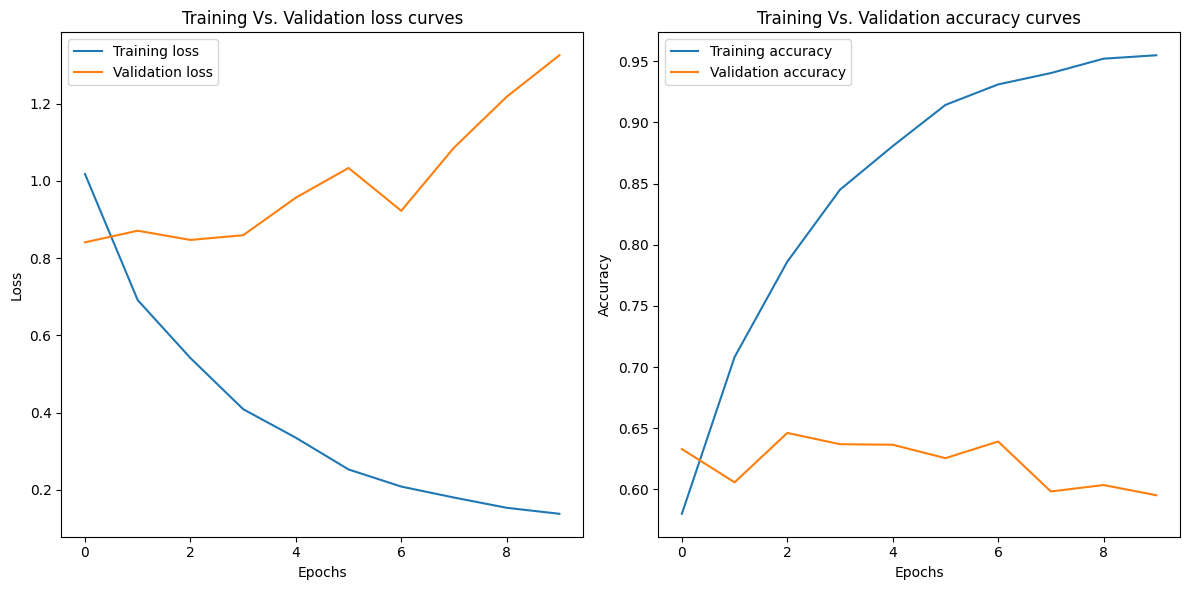

In [46]:
# Plot loss curves
plot_loss_curves(lenet_history, classification = True, val_data = True)

In [47]:
# lets evaluate the model on the val dataset
lenet_model.evaluate(validation_dataset)

72/72 [==============================] - 4s 48ms/step - loss: 1.3256 - accuracy: 0.5953 - top_k_accuracy: 1.0000


[1.3255585432052612, 0.5952590107917786, 1.0]

## 10. Make predictions on unseen data

In [48]:
# Evaluate the model on unseen data using a random image from the validation dataset
test_image = cv2.imread('/content/dataset/Emotions Dataset/Emotions Dataset/test/sad/108893.jpg')
im = tf.constant(test_image, tf.float32)
im = tf.expand_dims(im, axis = 0)
print(CLASS_NAMES[tf.argmax(lenet_model(im), axis = -1).numpy()[0]])

happy


### 10.1 Visualize and plot the predictions

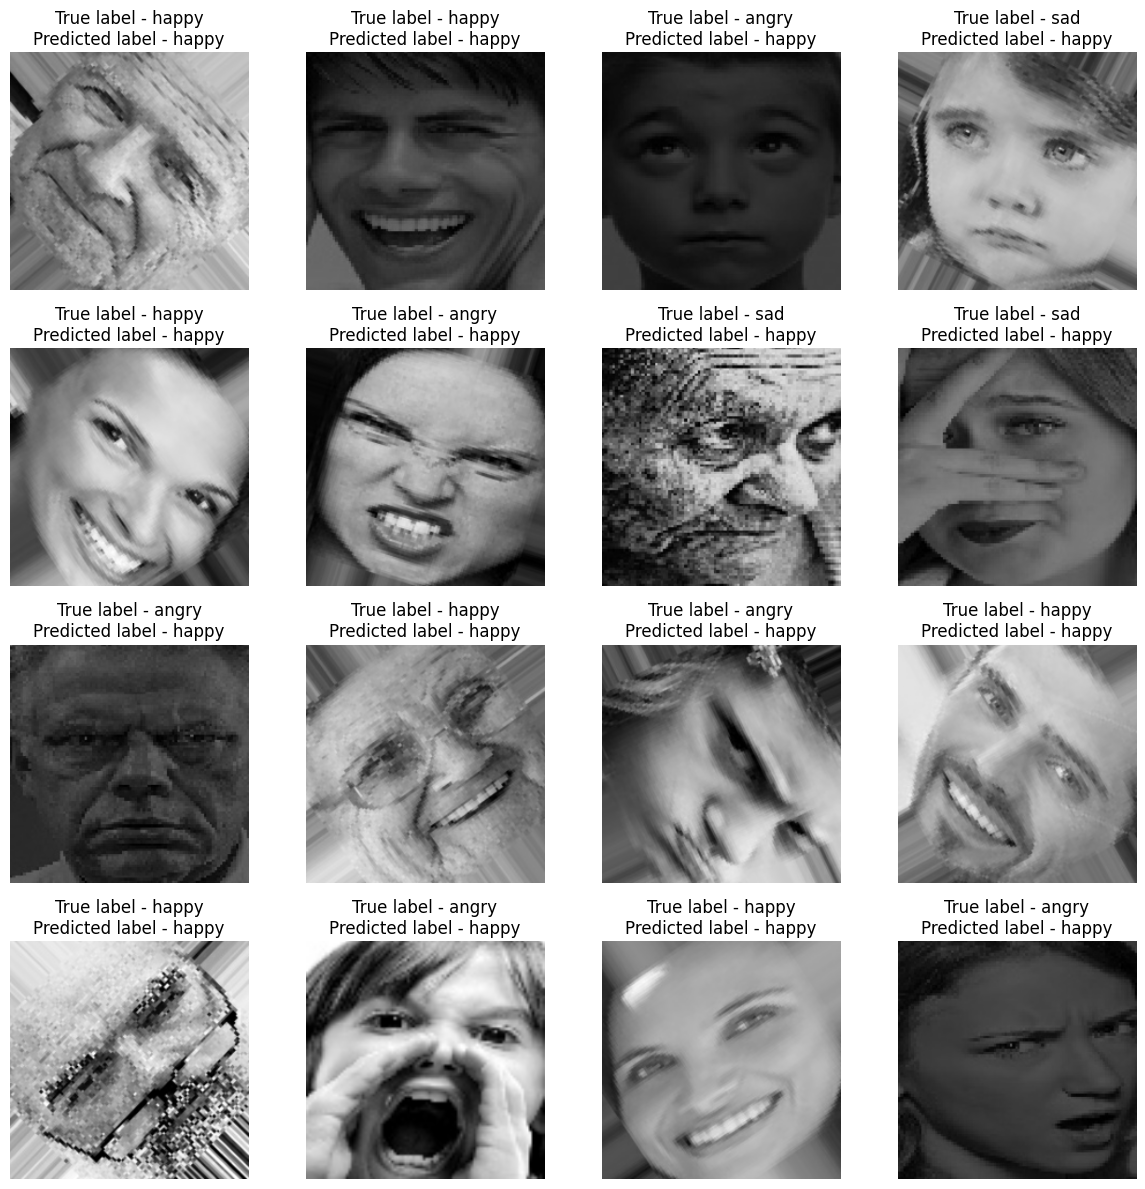

In [49]:
# Plot some images from the dataset
plt.figure(figsize = (12, 12))

for images, labels in validation_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i]/255.)
    plt.title("True label - " + CLASS_NAMES[tf.argmax(labels[i], axis = 0).numpy()]+ "\nPredicted label - "+ CLASS_NAMES[tf.argmax(lenet_model(im), axis = -1).numpy()[0]])
    plt.axis("off")

plt.tight_layout()

### 10.2 Plot the confusion matrix

Let's iterate over validation dataset to make predictions using lenet_model and store both the predictions and the true labels in a list for further analysis.

In [50]:
# Store the predictions of validation dataset in the list
predicted = []
labels = []

for im, label in validation_dataset:
  predicted.append(lenet_model(im))
  labels.append(label.numpy())

In [51]:
# Print the concatenated and flattened predictions and true labels from all batches in the validation dataset
print(np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()]))
print(np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()]))

[1 0 1 ... 1 1 0]
[0 2 0 ... 1 1 1]


[[818 149  39]
 [305 413  39]
 [259 131 125]]


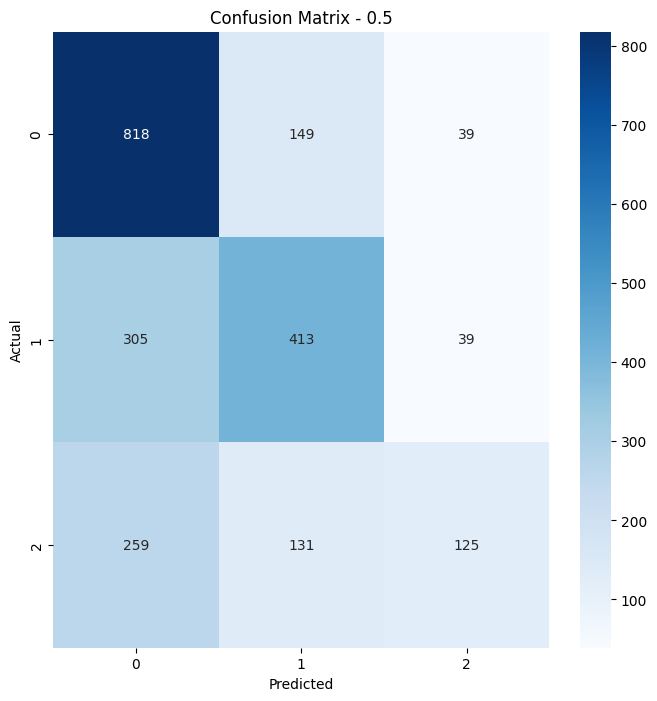

In [52]:
# Concatenate and flatten the predictions and true labels from all batches in the validation dataset.
pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])

# Set the threshold value for labelling 1 or 0
threshold = 0.5

# Create the confusion matrix
cm = confusion_matrix(lab, pred)
print(cm)

# Plotting the confusion matrix
plt.figure(figsize = (8,8))

sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues')
plt.title('Confusion Matrix - {}'.format(threshold))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

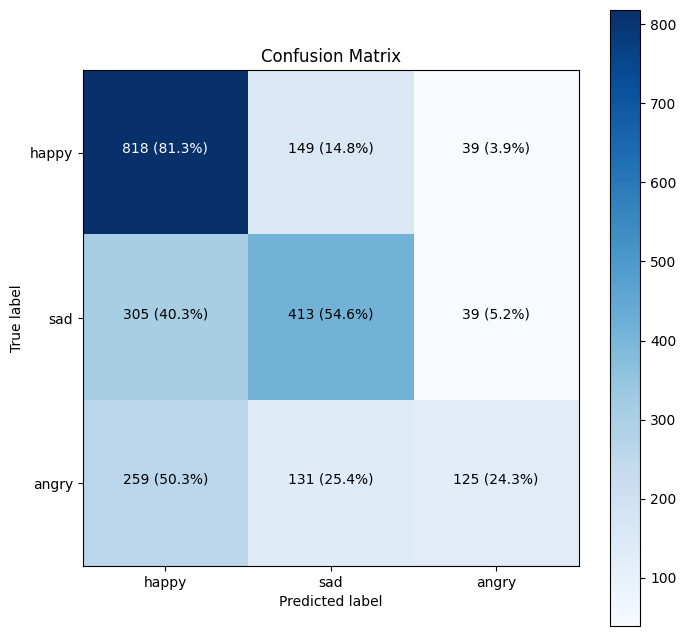

In [53]:
# Using our helper function to plot the confusion matrix
from helper_functions import make_confusion_matrix
make_confusion_matrix(y_true = lab,
                      y_pred = pred,
                      classes = CLASS_NAMES,
                      figsize = (8,8),
                      text_size = 10)

## 11. TFRecords

TensorFlow Records helps us build more efficient data pipelines as they help us store data which we use to train our models more efficiently. Also, they helps in parallelizing the reading of the data. Hence, helping in speeding up the overall training process.

**Why to use TensorFlow records?**
1. We store our data more efficiently.
2. We don't have to carry out the data preprocessing steps everytime.